In [199]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
np.random.seed(42)

Ваши задачи следующие:
1. Проанализировать данные, которые вам попались. Какие выводы можно сделать только из анализа? Проведите визуальный и статический анализ, опишите ваши находки.
2. Определите, какое моделирование доступно для ваших данных. Какие есть в них связи? 
3. Опишите возможные верхнеуровневые задачи, которые можно решать с помощью таких данных.
4. Очистите и обработайте данные. Опишите, какие в них были проблемы.
5. Постройте подходящую предсказательную модель. Обоснуйте ее выбор.
6. Выберите и обоснуйте метрики для ее оценки. Покажите, как модель работает на данных, которые не видела при обучении.
7. Представьте, что решаете реальную бизнес-задачу. Как вы могли бы использовать вашу модель? Какие бизнес-метрики могли бы быть использованы для ее контроля?

**Анализ**

In [200]:
data_path = '../../data/cleaned_cafe_sales_clean.csv'

In [201]:
df = pd.read_csv(data_path)
df = pd.DataFrame(df)
# print(df.head(),'\n')
print(df.info(),'\n')
print(df.head(),'\n')
print(df.columns,'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9988 non-null   object 
 1   Item              9988 non-null   object 
 2   Quantity          9988 non-null   float64
 3   Price Per Unit    9988 non-null   float64
 4   Total Spent       9988 non-null   float64
 5   Payment Method    9988 non-null   object 
 6   Location          9988 non-null   object 
 7   Transaction Date  9988 non-null   object 
dtypes: float64(3), object(5)
memory usage: 624.4+ KB
None 

  Transaction ID    Item  Quantity  Price Per Unit  Total Spent  \
0    TXN_1961373  Coffee       2.0             2.0          4.0   
1    TXN_4977031    Cake       4.0             3.0         12.0   
2    TXN_4271903  Cookie       4.0             1.0          4.0   
3    TXN_7034554   Salad       2.0             5.0         10.0   
4    TXN_3160411  Coffee    

analysis by time

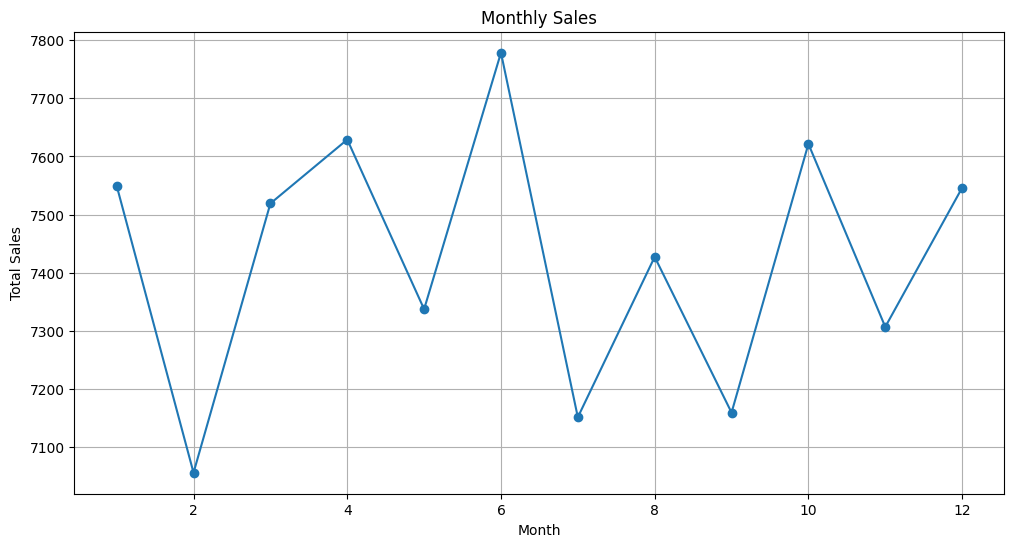

  0%|          | 0/1 [00:08<?, ?it/s]


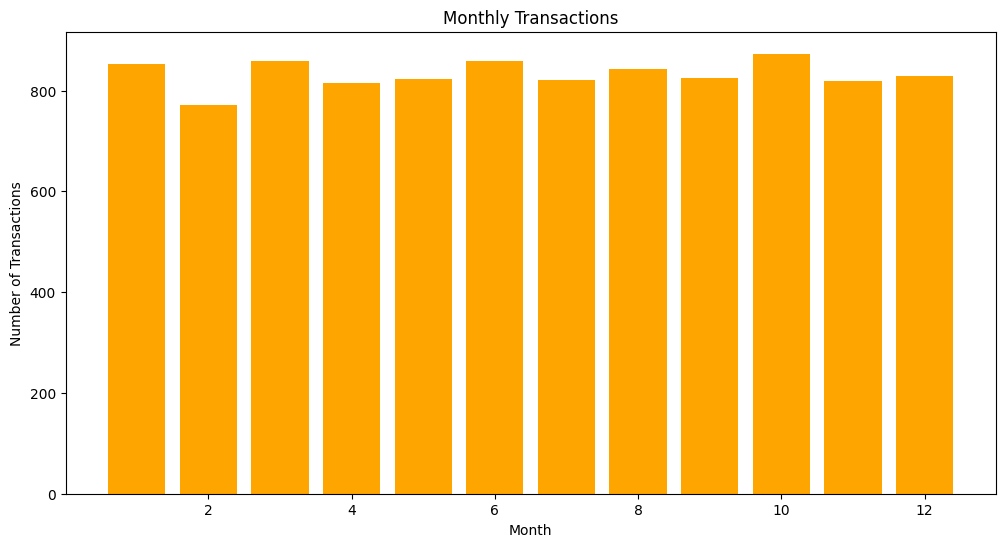

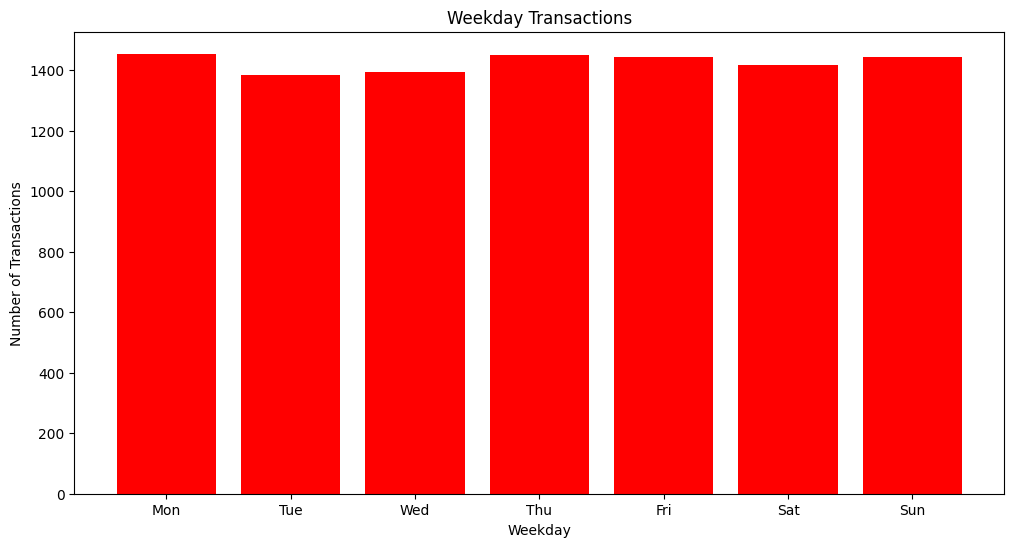

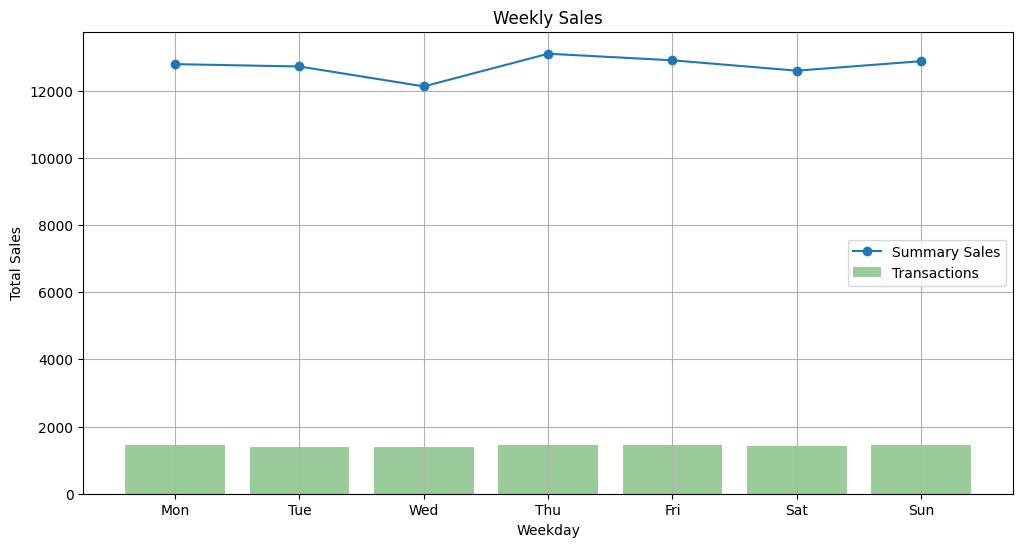

In [202]:
'''Анализ по времени:

Преобразуйте столбец с датами в формат datetime и постройте временной ряд общего объёма продаж или количества транзакций.
Проанализируйте сезонность, выделив месяцы, дни недели или праздничные периоды.
Сравните популярность товаров в разное время (например, завтрак против обеда).'''

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

df['Month'] = df['Transaction Date'].dt.month
df['Day'] = df['Transaction Date'].dt.day
df['Weekday'] = df['Transaction Date'].dt.weekday # 0...6

monthly_sales = df.groupby('Month')['Total Spent'].sum()
monthly_transactions = df.groupby('Month').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', label='.')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(monthly_transactions.index, monthly_transactions.values, color='orange', label='.')
plt.title('Monthly Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()

weekday_sales = df.groupby('Weekday')['Total Spent'].sum()
weekday_transactions = df.groupby('Weekday').size()

plt.figure(figsize=(12, 6))
plt.bar(weekday_transactions.index, weekday_transactions.values, color='red', label='.')
plt.title('Weekday Transactions')
plt.xlabel('Weekday')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(weekday_sales.index, weekday_sales.values, marker='o', label='Summary Sales')
plt.bar(weekday_transactions.index, weekday_transactions.values, color='green', label='Transactions', alpha=.4)
plt.title('Weekly Sales')
plt.xlabel('Weekday')
plt.ylabel('Total Sales')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.legend()
plt.show()


<dl>
Продажи: в целом люди покупают больше товары
- весной – начало лета, (видимо заскучались в феврале)
- в октябре и в декабре-январе (из-за смены сезона)<br>
 </dl> <br>
Низкие продажи: конец лета – начало осени, и февраль (отпуска? влияние смены сезона?) <br><br>
Однако, количество транзакций везде примерно одинаковое. Либо все же есть постоянники, либо точка в хорошем месте


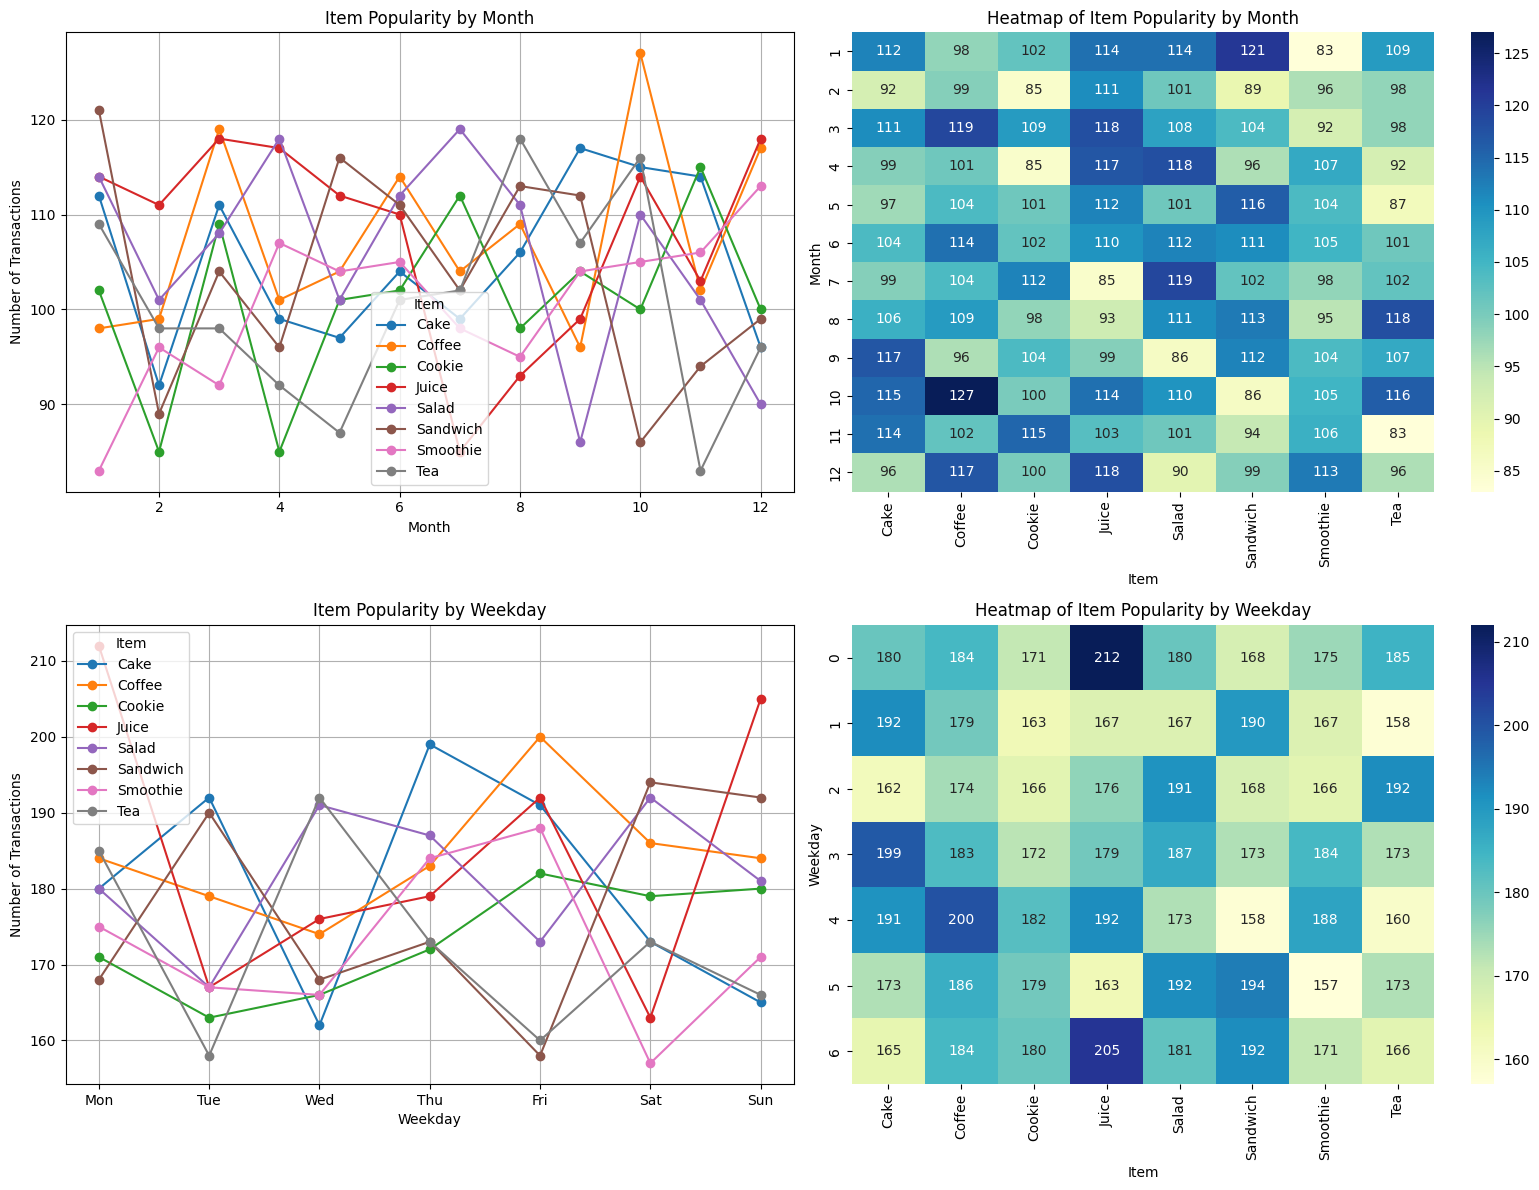

In [203]:
item_monthly = df.groupby(['Month', 'Item']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for item in item_monthly.columns:
    axes[0, 0].plot(item_monthly.index, item_monthly[item], marker='o', label=item)
axes[0, 0].set_title('Item Popularity by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Transactions')
axes[0, 0].legend(title='Item')
axes[0, 0].grid(True)


sns.heatmap(item_monthly, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Heatmap of Item Popularity by Month')
axes[0, 1].set_xlabel('Item')
axes[0, 1].set_ylabel('Month')


item_weekday = df.groupby(['Weekday', 'Item']).size().unstack(fill_value=0)

for item in item_weekday.columns:
    axes[1, 0].plot(item_weekday.index, item_weekday[item], marker='o', label=item)
axes[1, 0].set_title('Item Popularity by Weekday')
axes[1, 0].set_xlabel('Weekday')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].legend(title='Item')
axes[1, 0].grid(True)

sns.heatmap(item_weekday, annot=True, fmt='d', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Heatmap of Item Popularity by Weekday')
axes[1, 1].set_xlabel('Item')
axes[1, 1].set_ylabel('Weekday')

plt.tight_layout()
plt.show()

- Есть +- сезонные влияния на предпочтения клиентов (смузи покупают чаще осенью, торты тоже осенью, печенья летом)
- Кофе всегда любят
- Люди часто любят пить сок вс-пн, кофе, печенья, смузи под конец рабочей недели


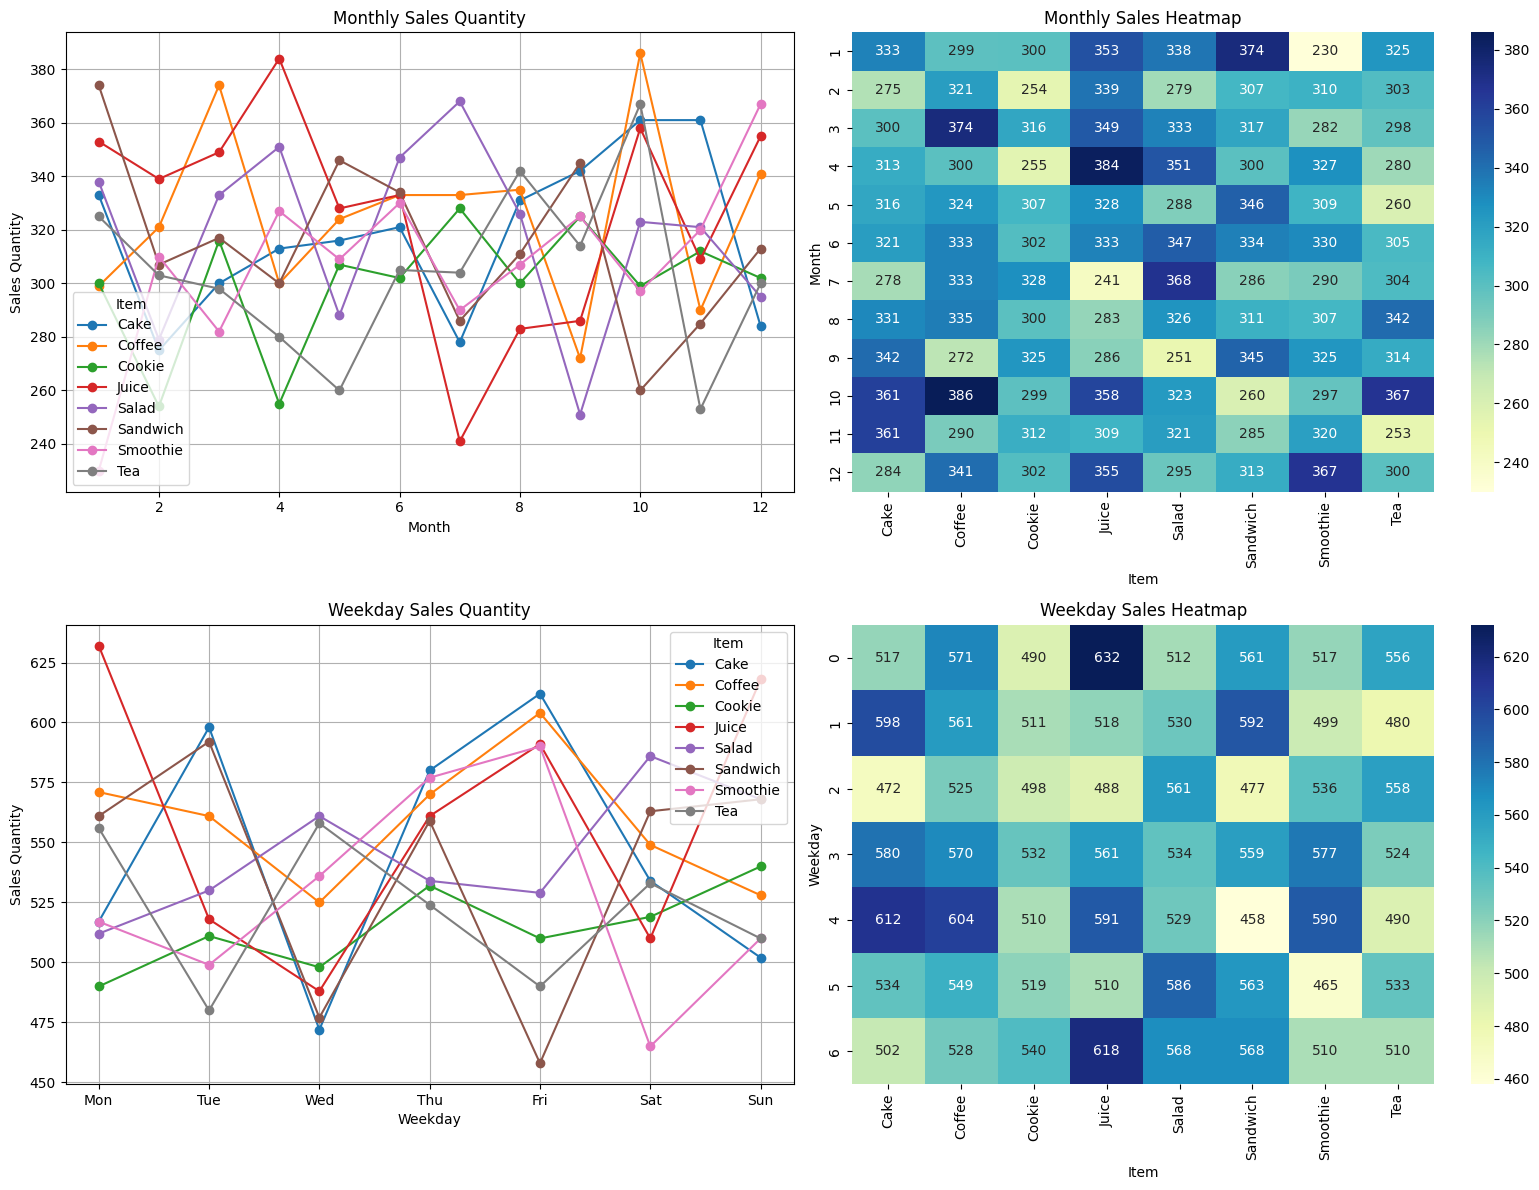

In [204]:
item_count_monthly = df.groupby(['Month', 'Item'])['Quantity'].sum().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for item in item_count_monthly.columns:
    axes[0, 0].plot(item_count_monthly.index, item_count_monthly[item], marker='o', label=item)
axes[0, 0].set_title('Monthly Sales Quantity')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Sales Quantity')
axes[0, 0].legend(title='Item')
axes[0, 0].grid(True)

sns.heatmap(item_count_monthly, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Monthly Sales Heatmap')
axes[0, 1].set_xlabel('Item')
axes[0, 1].set_ylabel('Month')

item_count_weekday = df.groupby(['Weekday', 'Item'])['Quantity'].sum().unstack(fill_value=0)

for item in item_count_weekday.columns:
    axes[1, 0].plot(item_count_weekday.index, item_count_weekday[item], marker='o', label=item)
axes[1, 0].set_title('Weekday Sales Quantity')
axes[1, 0].set_xlabel('Weekday')
axes[1, 0].set_ylabel('Sales Quantity')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1, 0].legend(title='Item')
axes[1, 0].grid(True)

sns.heatmap(item_count_weekday, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Weekday Sales Heatmap')
axes[1, 1].set_xlabel('Item')
axes[1, 1].set_ylabel('Weekday')

plt.tight_layout()
plt.show()

Summary of Sales by Location:
Location
In-store    44793.5
Takeaway    44286.0
Name: Total Spent, dtype: float64 

Avg Check by Location:
Location
In-store    8.974855
Takeaway    8.862518
Name: Total Spent, dtype: float64 

Transaction Count by Location:
Location
In-store    4991
Takeaway    4997
dtype: int64 



/var/folders/58/48pb_kg90fjcfmtvf1zy398r0000gn/T/ipykernel_10679/975328892.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Location', y='Total Spent', data=df, palette='Set3')


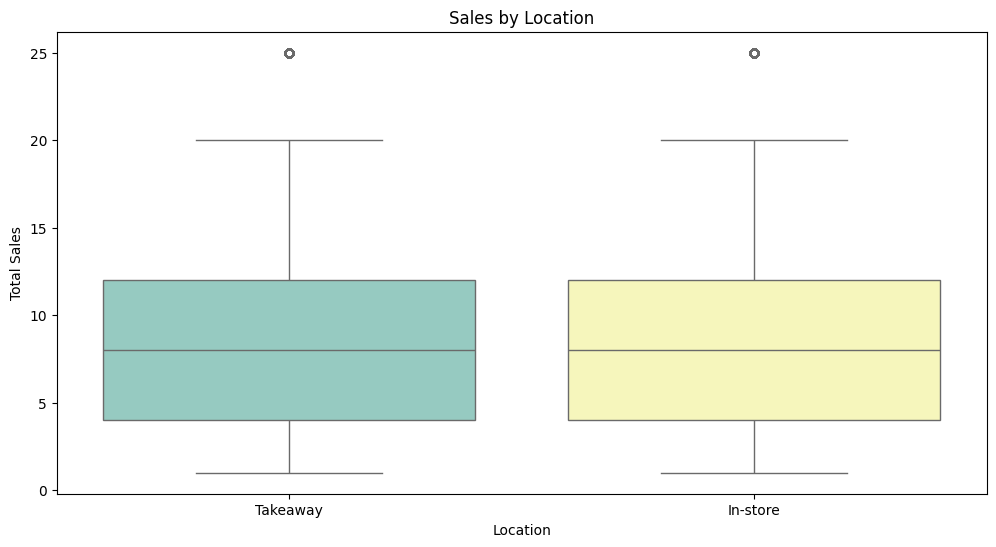

Item Popularity by Location:
Item      Cake  Coffee  Cookie  Juice  Salad  Sandwich  Smoothie  Tea
Location                                                             
In-store   639     628     604    643    630       623       619  605
Takeaway   623     662     609    651    641       620       589  602 



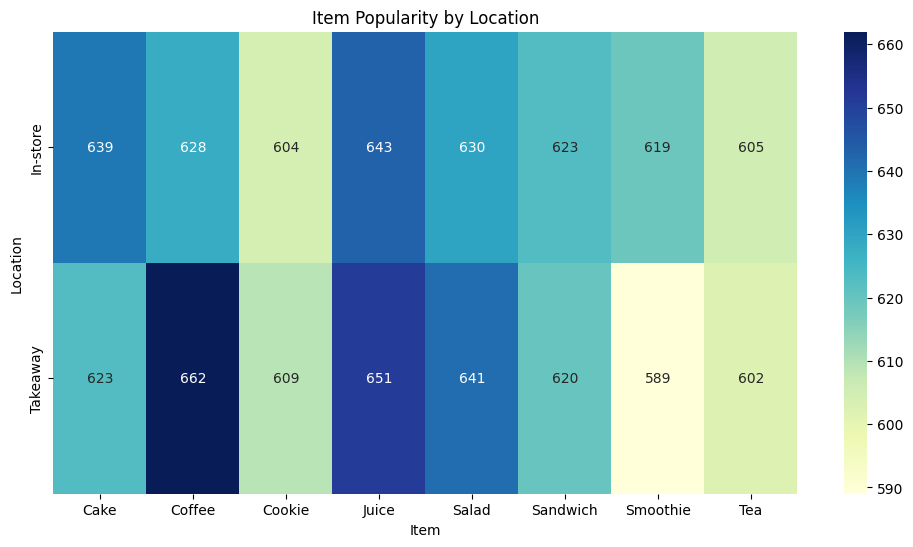

In [205]:
sales_by_location = df.groupby('Location')['Total Spent'].sum()
avg_transactions_by_location = df.groupby('Location')['Total Spent'].mean()
transaction_count_by_location = df.groupby('Location').size()

print("Summary of Sales by Location:")
print(sales_by_location, '\n')

print("Avg Check by Location:")
print(avg_transactions_by_location, '\n')

print("Transaction Count by Location:")
print(transaction_count_by_location, '\n')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='Total Spent', data=df, palette='Set3')
plt.title('Sales by Location')
plt.xlabel('Location')
plt.ylabel('Total Sales')
plt.show()

item_poularity_by_location = df.groupby(['Location', 'Item']).size().unstack(fill_value=0)

print("Item Popularity by Location:")
print(item_poularity_by_location, '\n')

plt.figure(figsize=(12, 6))
sns.heatmap(item_poularity_by_location, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Item Popularity by Location')
plt.xlabel('Item')
plt.ylabel('Location')
plt.show()




In-store и takeaway продажи полностью схожи. <br>

в In-store: чаще покупают кофе, салат <br>
в takeaway: чаще покупают торты, смузи <br>
соки покупают везде одинаково <br>

Cash              4834
Digital Wallet    2593
Credit Card       2561
Name: Payment Method, dtype: int64 



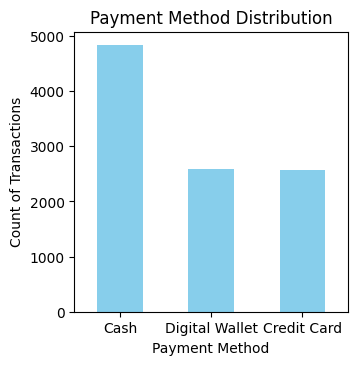

In [206]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

payment_counts = df['Payment Method'].value_counts()

ax1 = plt.subplot(gs[0, 0])
payment_counts.plot(kind='bar', color='skyblue', ax=ax1)
ax1.set_title('Payment Method Distribution')
ax1.set_xlabel('Payment Method')
ax1.set_ylabel('Count of Transactions')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

print(payment_counts, '\n')

Большая часть продаж осуществлены с помощью наличных.(48 %) <br>
***ВАЖНО!*** Это связано с тем, что в прошлом пункте мы большую часть заполнили наличными(потому что, это логичнее, чем заполнить все тремя способами оплаты (наличные сложно отслеживать, а карты всегда можно отследить. Поэтому если появляется nan в данных, то это либо касса сломалась и тогда транзакций некоторое время не должно быть, либо это наличка. Первый вариант лучше ()_() .).).
<br><br>



Давайте попробуем провести ассоциативный анализ. <br>
Какие товары покупают вместе часто?

In [207]:
transactions = df.groupby('Transaction ID')['Item'].apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


Ассоциативные алгоритм apriori/fp-growth не нашли частых наборов <br>

Попробуем кластеризовать транзакции по кол-ву покупок и итоговой сумме

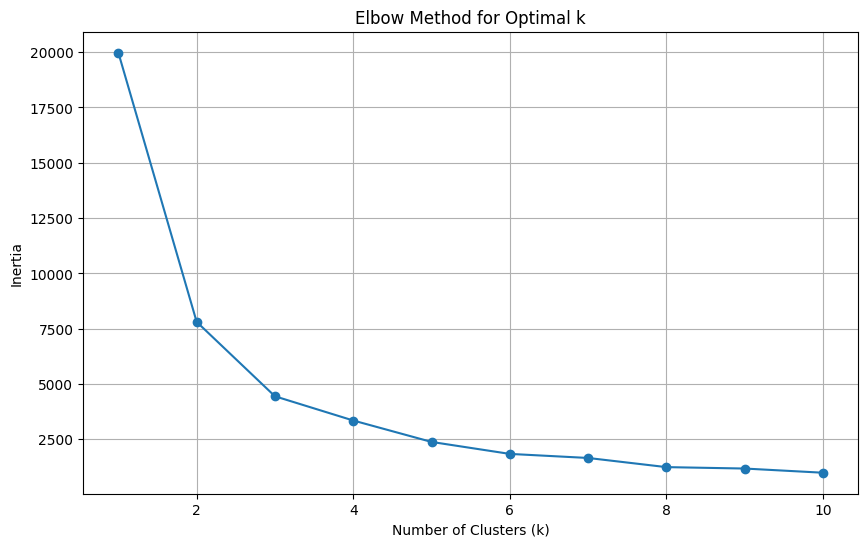

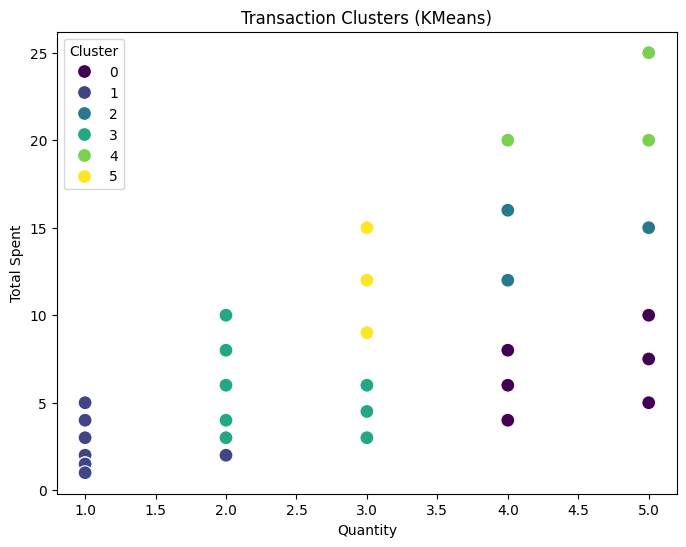

Cluster Summary:
         Quantity                  Total Spent                   
             mean median  min  max        mean median   min   max
Cluster                                                          
0        4.513712    5.0  4.0  5.0    6.834114    7.5   4.0  10.0
1        1.118983    1.0  1.0  2.0    2.840372    3.0   1.0   5.0
2        4.358957    4.0  4.0  5.0   14.322861   15.0  12.0  16.0
3        2.282226    2.0  2.0  3.0    5.872298    6.0   3.0  10.0
4        4.760417    5.0  4.0  5.0   21.268939   20.0  20.0  25.0
5        3.000000    3.0  3.0  3.0   11.323127   12.0   9.0  15.0 



In [208]:
features = df[['Quantity', 'Total Spent']].copy()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features_scaled)
df['Cluster'] = clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Quantity', y='Total Spent', hue='Cluster', data=df, palette='viridis', s=100)
plt.title('Transaction Clusters (KMeans)')
plt.xlabel('Quantity')
plt.ylabel('Total Spent')
plt.legend(title='Cluster')
plt.show()

cluster_summary = df.groupby('Cluster')
print("Cluster Summary:")
print(cluster_summary[['Quantity', 'Total Spent']].agg(['mean', 'median', 'min', 'max']), '\n')

Бизнес-кафе <br>
Мы можем здесь принять некоторые решения <br><br>

Мы можем выделить несколько сегментов клиентов:
- 0: покупают 4-5 позиций по низкой цене
    - можно около кассы (только in-store) ставить недорогие печеньки, сладости, которые подходят под кафе-формат, или предлагать акции типа 1=2. Это чтобы подтолкнуть их к покупке чего-то еще
- 1: покупают 1-2 товара за низкий прайс
    - ориентир на импульсные покупки (cross-selling); когда человек пришел за чем-то конкретным, но в итоге купил маленький тортик к кофе
- 2: чисто средние покупки
    - можно посмотреть на возможность запуска программ лояльности, чтобы подтолкнуть их к покупке чего-то еще, если ее нет еще
- 3: чуть выше, чем 1 сегмент клиентов
    - тут можно идти по пути 1-го или по пути комплексных предложений(как готовые меню с минимальных выбором товаров в кафешках)
- 4: клиенты vip
    - чтобы они не забывали про нас, нужно не забывать про обслуживание и качество, а также предлагать им что-то новое или экслюзивное
- 5: эти клиенты тоже среднячки, 2 сегмент

***Попробуем какой-нибудь прогноз сделать***

- ***Прогнозирование продаж?***

In [209]:

def linear_and_poly_model(degree: int, X: np.ndarray, y: np.ndarray) -> tuple:
    '''Fit linear and polynomial models and return them'''
    # X = X.reshape((-1, 1))
    
    # linear model
    model_basic = LinearRegression().fit(X, y)
    
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    model_poly = LinearRegression().fit(X_poly, y)
    
    return model_basic, [model_poly, X_poly]

def calc_best_degree(X: np.ndarray, y: np.ndarray, **kwargs) -> tuple:
    '''Calculate best degree of poly model, returns 
        (history_mse, history_score), (best_mse, best_score),
        best_degree, fitted model, X_poly
    *args: min_degree, max_degree, step, polyfeatures
    '''
    min_degree, max_degree, step = kwargs.get('min_degree', 1), kwargs.get('max_degree', 15), kwargs.get('step', 1)
    degrees = np.arange(min_degree, max_degree+1, step)
    
    history_score = []
    history_mse = []
    
    # X = X.reshape((-1, 1))
    
    best_degree = degrees[0]
    best_model = None
    best_X_poly = None
    best_mse = np.inf
    best_score = 0
    
    for degree in degrees:
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)
        model_poly = LinearRegression().fit(X_poly, y)
        y_poly = model_poly.predict(X_poly)
        
        mse = mean_squared_error(y, y_poly)
        score = model_poly.score(X_poly, y)
        
        history_mse.append(mse)
        history_score.append(score)
        
        if score > best_score:
            best_mse = mse
            best_degree = degree
            best_model = model_poly
            best_X_poly = X_poly
            best_score = score
    
    return (history_mse, history_score), (best_mse, best_score), best_degree, best_model, best_X_poly
    

Mean Squared Error (MSE): 45682.695342851606
Coefficient: [0.80594406] Intercept: 7418.858974358975
Score: 0.00016941009442927868
Mean Squared Error (Polynomial Regression): 43536.12919487928
Polynomial Coefficients: [  0.          97.03300403 -23.79451104   1.47779073] Intercept: 7356.507326007324
Polynomial Score: 0.047150055213792674
Best Degree: 7
SELECTED DEGREE: 3


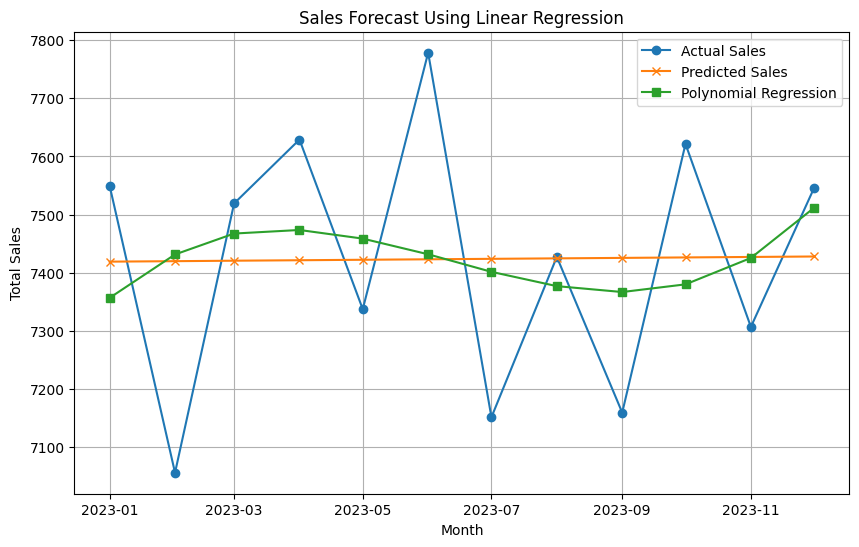

In [210]:

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df['Month'] = df['Transaction Date'].dt.to_period('M')

monthly_sales = df.groupby('Month')['Total Spent'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()
monthly_sales = monthly_sales.sort_values('Month').reset_index(drop=True)

monthly_sales['TimeIndex'] = np.arange(len(monthly_sales))

X = monthly_sales[['TimeIndex']]
y = monthly_sales['Total Spent']

lr = LinearRegression()
lr.fit(X, y)
monthly_sales['Predicted'] = lr.predict(X)


mse = mean_squared_error(y, monthly_sales['Predicted'])
print("Mean Squared Error (MSE):", mse)
print("Coefficient:", lr.coef_, "Intercept:", lr.intercept_)
print("Score:", lr.score(X, y))


f = calc_best_degree(X, y, min_degree=1, max_degree=7, step=1)
best_degree = f[2]
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X)
plr = LinearRegression().fit(X_poly, y)
monthly_sales['PLRPredicted'] = plr.predict(X_poly)

mse = mean_squared_error(y, monthly_sales['PLRPredicted'])
print("Mean Squared Error (Polynomial Regression):", mse)
print("Polynomial Coefficients:", plr.coef_, "Intercept:", plr.intercept_)
print("Polynomial Score:", plr.score(X_poly, y))
print("Best Degree:", best_degree)
print("SELECTED DEGREE:", 3)


plt.figure(figsize=(10,6))
plt.plot(monthly_sales['Month'], y, label='Actual Sales', marker='o')
plt.plot(monthly_sales['Month'], monthly_sales['Predicted'], label='Predicted Sales', marker='x')
plt.plot(monthly_sales['Month'], monthly_sales['PLRPredicted'], label='Polynomial Regression', marker='s')
plt.title('Sales Forecast Using Linear Regression')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


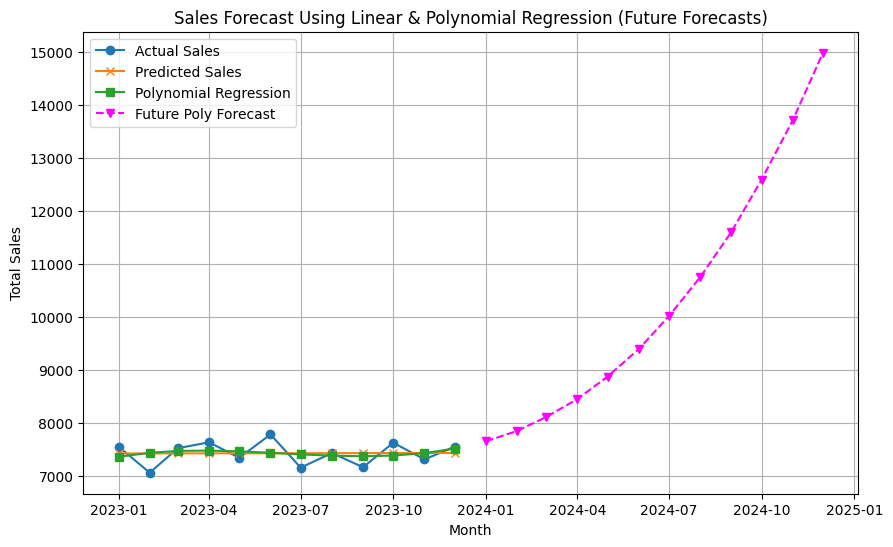

In [211]:
n_future = 12
last_month = monthly_sales['Month'].iloc[-1]
future_months = [last_month + pd.DateOffset(months=i+1) for i in range(n_future)]
future_index = np.arange(len(monthly_sales), len(monthly_sales) + n_future).reshape(-1, 1)

future_linear_pred = lr.predict(future_index)
future_index_poly = poly_features.transform(future_index)
future_poly_pred = plr.predict(future_index_poly)

future_df = pd.DataFrame({
    'Month': future_months,
    'TimeIndex': future_index.flatten(),
    # 'LinearForecast': future_linear_pred,
    'PolyForecast': future_poly_pred
})

plt.figure(figsize=(10,6))
plt.plot(monthly_sales['Month'], y, label='Actual Sales', marker='o')
plt.plot(monthly_sales['Month'], monthly_sales['Predicted'], label='Predicted Sales', marker='x')
plt.plot(monthly_sales['Month'], monthly_sales['PLRPredicted'], label='Polynomial Regression', marker='s')
# plt.plot(future_df['Month'], future_df['LinearForecast'], label='Future Linear Forecast', marker='^', linestyle='--', color='orange')
plt.plot(future_df['Month'], future_df['PolyForecast'], label='Future Poly Forecast', marker='v', linestyle='--', color='magenta')
plt.title('Sales Forecast Using Linear & Polynomial Regression (Future Forecasts)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


Полиномиальная регрессия хорошо прогнозирует настоящее время при хороших степенях, но плохо будущее <br>
Я выбрал degree = 3. Score и mse ужасные, зато показывает тренд, который можно использовать для прогноза при расширении бизнеса <br> 

Попробуем prophet (facebook)

In [231]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

n_future = 12

df_prophet = monthly_sales[['Month', 'Total Spent']].rename(columns={'Month': 'ds', 'Total Spent': 'y'})

# find best parameters
changepoint_scaled = [.01, .1, .5]
seasonality_scales = [1.0, 5.0]
seasonality_modes = ['additive', 'multiplicative']

results = []

for cps, ss, sm in itertools.product(changepoint_scaled, seasonality_scales, seasonality_modes):
    model = Prophet(
        changepoint_prior_scale=cps,
        seasonality_prior_scale=ss,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode=sm,
    )
    model.fit(df_prophet)
    
    #cross-validation
    df_cv = cross_validation(model, initial='230 days', period='180 days', horizon='90 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse = df_p['rmse'].mean()
    results.append({
        'changepoint_prior_scale': cps,
        'seasonality_prior_scale': ss,
        'seasonality_mode': sm,
        'rmse': rmse
    })
    
results_df = pd.DataFrame(results)
print(results_df.sort_values('rmse'))


18:42:56 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/1 [00:00<?, ?it/s]18:42:59 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:02<00:00,  2.15s/it]
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing ini

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
5                      0.10                      1.0   multiplicative   
4                      0.10                      1.0         additive   
1                      0.01                      1.0   multiplicative   
8                      0.50                      1.0         additive   
9                      0.50                      1.0   multiplicative   
10                     0.50                      5.0         additive   
7                      0.10                      5.0   multiplicative   
3                      0.01                      5.0   multiplicative   
2                      0.01                      5.0         additive   
6                      0.10                      5.0         additive   
0                      0.01                      1.0         additive   
11                     0.50                      5.0   multiplicative   

            rmse  
5    3384.847196  
4    6600.15

rmse наилучший - 3384.847196. Выбираем multiplicative, так как у нас есть явные сезонные колебания. <br>
Но rmse вроде обычный для объемов в тысячах юнитов, но давайте проверим: сравним с средним и медианным и рассчитаем mape <br>

In [237]:
cps = .1
ss = 1.0
sm = 'multiplicative'

model = Prophet(
    changepoint_prior_scale=cps,
    seasonality_prior_scale=ss,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode=sm,
)
model.fit(df_prophet)

#cross-validation
df_cv = cross_validation(model, initial='230 days', period='180 days', horizon='90 days')
df_p = performance_metrics(df_cv, rolling_window=1)
rmse = df_p['rmse'].mean()
results.append({
    'changepoint_prior_scale': cps,
    'seasonality_prior_scale': ss,
    'seasonality_mode': sm,
    'rmse': rmse
})


mean_sales = df_prophet['y'].mean()
median_sales = df_prophet['y'].median()

print("Mean Sales:", mean_sales)
print('Median Sales:', median_sales)

rmse_final = 3384.847196

perc_error = (rmse_final / mean_sales) * 100
print("Percentage Error:", perc_error, '%')

df_cv['mape'] = abs(df_cv['y'] - df_cv['yhat']) / df_cv['y']
mape = df_cv['mape'].mean() * 100
print("Mean Absolute Percentage Error (MAPE):", mape, '%')

18:47:14 - cmdstanpy - INFO - Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:47:24 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:08<00:00,  8.48s/it]

Mean Sales: 7423.291666666667
Median Sales: 7473.0
Percentage Error: 45.5976586666966 %
Mean Absolute Percentage Error (MAPE): 43.692127029385794 %


mape выше обычного - 43%. Достаточно много для бизнес-прогноза. на графики можно опираться, но с скепсисом. <br>

18:52:48 - cmdstanpy - INFO - Chain [1] start processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing


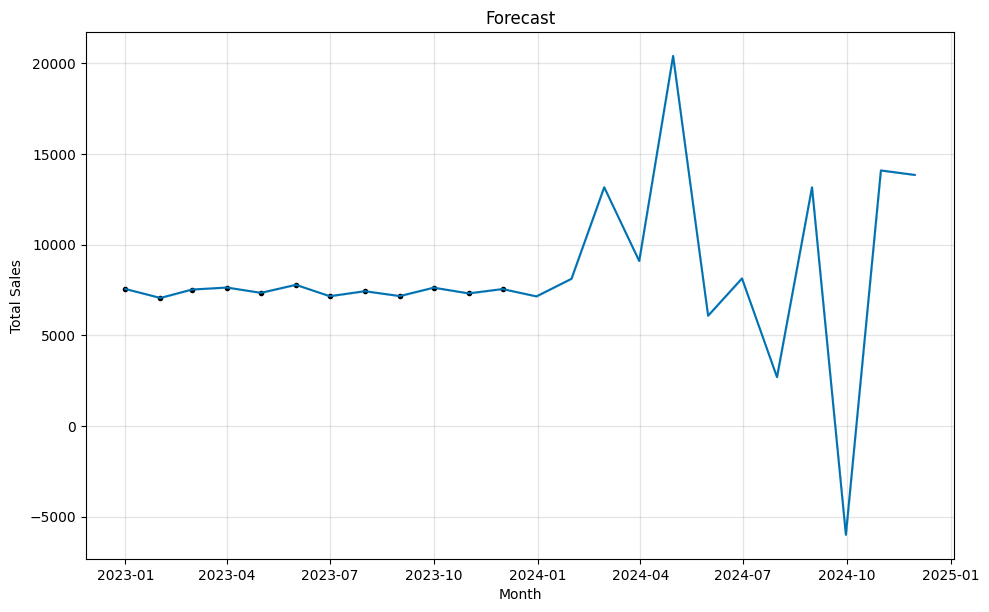

In [240]:
model = Prophet(
    changepoint_prior_scale=cps,
    seasonality_prior_scale=ss,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode=sm,
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title('Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

In [ ]:
df.hea